In [ ]:
import torch
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torchvision
import json
from tqdm.auto import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from google.colab.patches import cv2_imshow
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(640, 640)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

# Setup path to data folder
data_path = Path("/content/drive/MyDrive/Colab Notebooks/OpenCV/KTP-classifier/KTP.v1i.folder")

data_train = os.path.join(data_path, 'train')
data_validation = os.path.join(data_path, 'valid')
data_test = os.path.join(data_path, 'test')

train_data = datasets.ImageFolder(root=data_train,
                                 transform=auto_transforms,
                                 target_transform=None)

valid_data = datasets.ImageFolder(root=data_validation,
                                transform=auto_transforms)


test_data = datasets.ImageFolder(root=data_test,
                                transform=auto_transforms)

In [ ]:
class_names = train_data.classes
class_names

['ktp', 'nonktp']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'ktp': 0, 'nonktp': 1}

In [ ]:
len(train_data), len(valid_data), len(test_data)

(165, 17, 7)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1.2617, -1.2788, -1.2959,  ..., -0.0801, -0.1486, -0.1828],
         [-1.2788, -1.2959, -1.3130,  ..., -0.0801, -0.1657, -0.2342],
         [-1.3130, -1.3302, -1.3473,  ..., -0.0801, -0.1657, -0.2513],
         ...,
         [-0.7308, -0.0801, -0.2171,  ...,  0.4851,  0.4679,  0.4851],
         [-0.7822, -0.1486, -0.2684,  ...,  0.5022,  0.4851,  0.3994],
         [-0.7479, -0.1657, -0.1657,  ...,  0.5878,  0.4679,  0.4337]],

        [[-1.6331, -1.6506, -1.6681,  ...,  0.3452,  0.2752,  0.2402],
         [-1.6506, -1.6506, -1.6681,  ...,  0.3627,  0.2577,  0.1877],
         [-1.6506, -1.6506, -1.6681,  ...,  0.3627,  0.2577,  0.1877],
         ...,
         [-0.7052,  0.1527,  0.1527,  ...,  1.0280,  1.0105,  1.0280],
         [-0.7577,  0.1001,  0.1176,  ...,  1.0455,  1.0280,  0.9405],
         [-0.7227,  0.0826,  0.2227,  ...,  1.1331,  1.0105,  0.9755]],

        [[-1.3164, -1.3339, -1.3513,  ...,  1.2631,  1.2631,  1.2108],
         [-1.3339, -1.3513, -1.

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

valid_dataloader = DataLoader(dataset=valid_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data


train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7af083308d60>,
 <torch.utils.data.dataloader.DataLoader at 0x7af08330a5c0>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
class KTPClassifier(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            # nn.Linear(in_features=64000,
            #           out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.block_3(x)
        # print(x.shape)
        x = self.block_4(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model = KTPClassifier(input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model

KTPClassifier(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
   import torchinfo
except:
   !pip install torchinfo
   import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 640, 640], col_names=["input_size", "output_size", "num_params", "trainable"]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
KTPClassifier                            [1, 3, 640, 640]          [1, 16000]                --                        True
├─Sequential: 1-1                        [1, 3, 640, 640]          [1, 10, 320, 320]         --                        True
│    └─Conv2d: 2-1                       [1, 3, 640, 640]          [1, 10, 640, 640]         280                       True
│    └─ReLU: 2-2                         [1, 10, 640, 640]         [1, 10, 640, 640]         --                        --
│    └─Conv2d: 2-3                       [1, 10, 640, 640]         [1, 10, 640, 640]         910                       True
│    └─ReLU: 2-4                         [1, 10, 640, 640]         [1, 10, 640, 640]         --                        --
│    └─MaxPool2d: 2-5                    [1, 10, 640, 640]         [1, 10, 320, 320]         --                        --
├─Sequent

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# Setup pretrained model
weights=EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Freeze the base layers in the model (this will freeze all layers to begin with)
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Update the classifier head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280,
              out_features=2))

In [ ]:
# Check out EffNetB2 classifier head
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
   import torchinfo
except:
   !pip install torchinfo
   import torchinfo

from torchinfo import summary
summary(model, input_size=(2, 3, 640, 640), col_names=["input_size", "output_size", "num_params", "trainable"]) # do a test pass through of an example input size

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [2, 3, 640, 640]          [2, 2]                    --                        Partial
├─Sequential: 1-1                                       [2, 3, 640, 640]          [2, 1280, 20, 20]         --                        False
│    └─Conv2dNormActivation: 2-1                        [2, 3, 640, 640]          [2, 32, 320, 320]         --                        False
│    │    └─Conv2d: 3-1                                 [2, 3, 640, 640]          [2, 32, 320, 320]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [2, 32, 320, 320]         [2, 32, 320, 320]         (64)                      False
│    │    └─SiLU: 3-3                                   [2, 32, 320, 320]         [2, 32, 320, 320]         --                        --
│    └─Sequential

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [ ]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() #nn.BCELoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=valid_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.73727 | Train accuracy: 49.70%
Test loss: 0.70548 | Test accuracy: 47.06%

Epoch: 1
---------
Train loss: 0.28722 | Train accuracy: 92.12%
Test loss: 0.30013 | Test accuracy: 88.24%

Epoch: 2
---------
Train loss: 0.10384 | Train accuracy: 98.79%
Test loss: 0.18945 | Test accuracy: 94.12%

Epoch: 3
---------
Train loss: 0.06424 | Train accuracy: 100.00%
Test loss: 0.17666 | Test accuracy: 94.12%

Epoch: 4
---------
Train loss: 0.04620 | Train accuracy: 100.00%
Test loss: 0.17515 | Test accuracy: 94.12%

Train time on cuda: 70.642 seconds


In [ ]:
from pathlib import Path

data_path = Path("/content/drive/MyDrive/Colab Notebooks/OpenCV/KTP-classifier")

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("/content/drive/MyDrive/Colab Notebooks/OpenCV/KTP-classifier")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: /content/drive/MyDrive/Colab Notebooks/OpenCV/KTP-classifier/03_pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = efficientnet_b0()

# Update the classifier head
loaded_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1280, # keep in_features same
              out_features=2)) # change out_features to suit our number of classes

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [ ]:
from typing import List, Tuple

from PIL import Image

# Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

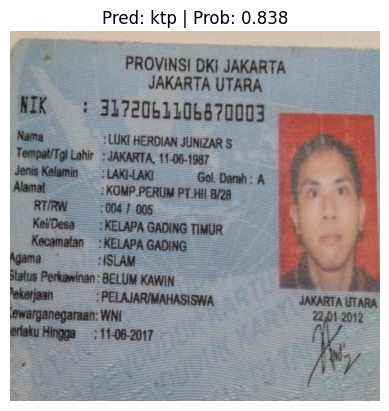

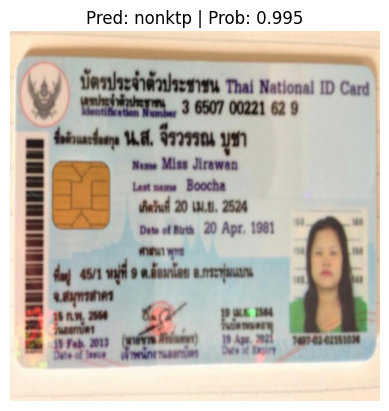

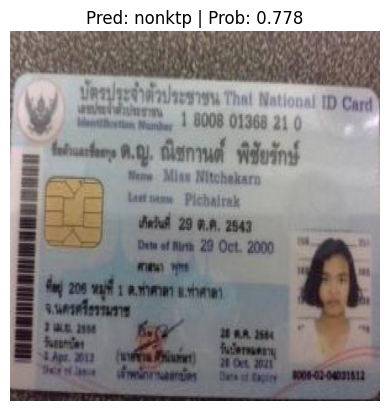

In [ ]:
test_dir = Path("/content/drive/MyDrive/Colab Notebooks/OpenCV/KTP-classifier/KTP.v1i.folder/test")

# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=loaded_model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))